In [1]:
# Models
from lightgbm import LGBMRegressor

# Model selection
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.metrics import r2_score, mean_absolute_error

# Model tuning
from functools import partial
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.pyll.base import scope

# Data handling
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Feature handling
from sklearn.preprocessing import StandardScaler, RobustScaler, SplineTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

# Math
import numpy as np

# Display
sns.set_style('darkgrid')

In [2]:
train_data = pd.read_csv('train.csv', index_col=0).sort_index()
test_data = pd.read_csv('test.csv', index_col=0).sort_index()

In [3]:
train_data.sample(5)

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Energy city
36622,09/11/2021/07:40,22.7424,71.80,0.28222,88.100,35.700,57313.331021
145,01/01/2021/00:10,13.1222,77.30,0.08034,0.084,0.108,62856.893599
33705,08/22/2021/01:30,24.2977,56.59,5.07275,0.117,0.074,75453.406535
41817,10/17/2021/09:30,21.8257,85.40,0.07828,57.010,47.180,63201.013529
3340,01/23/2021/04:40,12.0922,76.00,0.09682,0.051,0.115,51531.710280


In [4]:
test_data.sample(5)

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Energy city
34702,08/28/2021/23:40,27.1302,90.50,5.06451,0.073,0.137,0
50382,12/15/2021/21:00,16.0062,80.20,0.08446,0.048,0.163,0
10855,03/16/2021/09:10,13.7402,90.00,0.07313,346.600,219.700,0
47132,11/23/2021/07:20,11.5360,59.66,5.06554,0.055,0.108,0
2617,01/18/2021/04:10,15.4706,84.00,0.08446,0.088,0.141,0


In [5]:
class DatetimeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transform_train=True):
        self.transform_train = transform_train

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.copy()
        X_['DateTime'] = pd.to_datetime(X_['DateTime'], format='%m/%d/%Y/%H:%M')
        
        # Base
        X_['year'] = X_['DateTime'].dt.year
        X_['month'] = X_['DateTime'].dt.month
        X_['weekday'] = X_['DateTime'].dt.weekday + 1
        X_['hour'] = X_['DateTime'].dt.hour

        # Cycle
        X_['month_sin'] = np.sin(np.pi * 2 * X_['month'] / 12)
        X_['month_cos'] = np.cos(np.pi * 2 * X_['month'] / 12)
        X_['weekday_sin'] = np.sin(np.pi * 2 * X_['weekday'] / 7)
        X_['weekday_cos'] = np.cos(np.pi * 2 * X_['weekday'] / 7)
        X_['hour_sin'] = np.sin(np.pi * 2 * X_['hour'] / 12)
        X_['hour_cos'] = np.cos(np.pi * 2 * X_['hour'] / 12)

        if self.transform_train:
            X_ = X_.drop(['DateTime', 'year'], axis=1)

        return X_

In [6]:
datetime_preproc = DatetimeTransformer(transform_train=False)
train_data_preproc = datetime_preproc.transform(train_data)
test_data_preproc = datetime_preproc.transform(test_data)
train_data_preproc.sample(5)

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Energy city,year,month,weekday,hour,month_sin,month_cos,weekday_sin,weekday_cos,hour_sin,hour_cos
35314,2021-09-02 05:40:00,22.6188,58.02,5.07069,0.080,0.089,49830.971839,2021,9,4,5,-1.000000e+00,-1.836970e-16,-4.338837e-01,-0.900969,0.500000,-0.866025
5594,2021-02-07 20:20:00,11.7935,84.50,5.06554,0.055,0.171,95244.555085,2021,2,7,20,8.660254e-01,5.000000e-01,-2.449294e-16,1.000000,-0.866025,-0.500000
51047,2021-12-20 11:50:00,19.1271,64.85,0.08034,163.000,165.700,68062.404341,2021,12,1,11,-2.449294e-16,1.000000e+00,7.818315e-01,0.623490,-0.500000,0.866025
22668,2021-06-06 10:00:00,24.8436,77.40,0.07107,666.300,639.800,66247.783955,2021,6,7,10,1.224647e-16,-1.000000e+00,-2.449294e-16,1.000000,-0.866025,0.500000
13584,2021-04-04 08:00:00,17.9632,86.00,0.07004,34.340,30.520,58714.368261,2021,4,7,8,8.660254e-01,-5.000000e-01,-2.449294e-16,1.000000,-0.866025,-0.500000


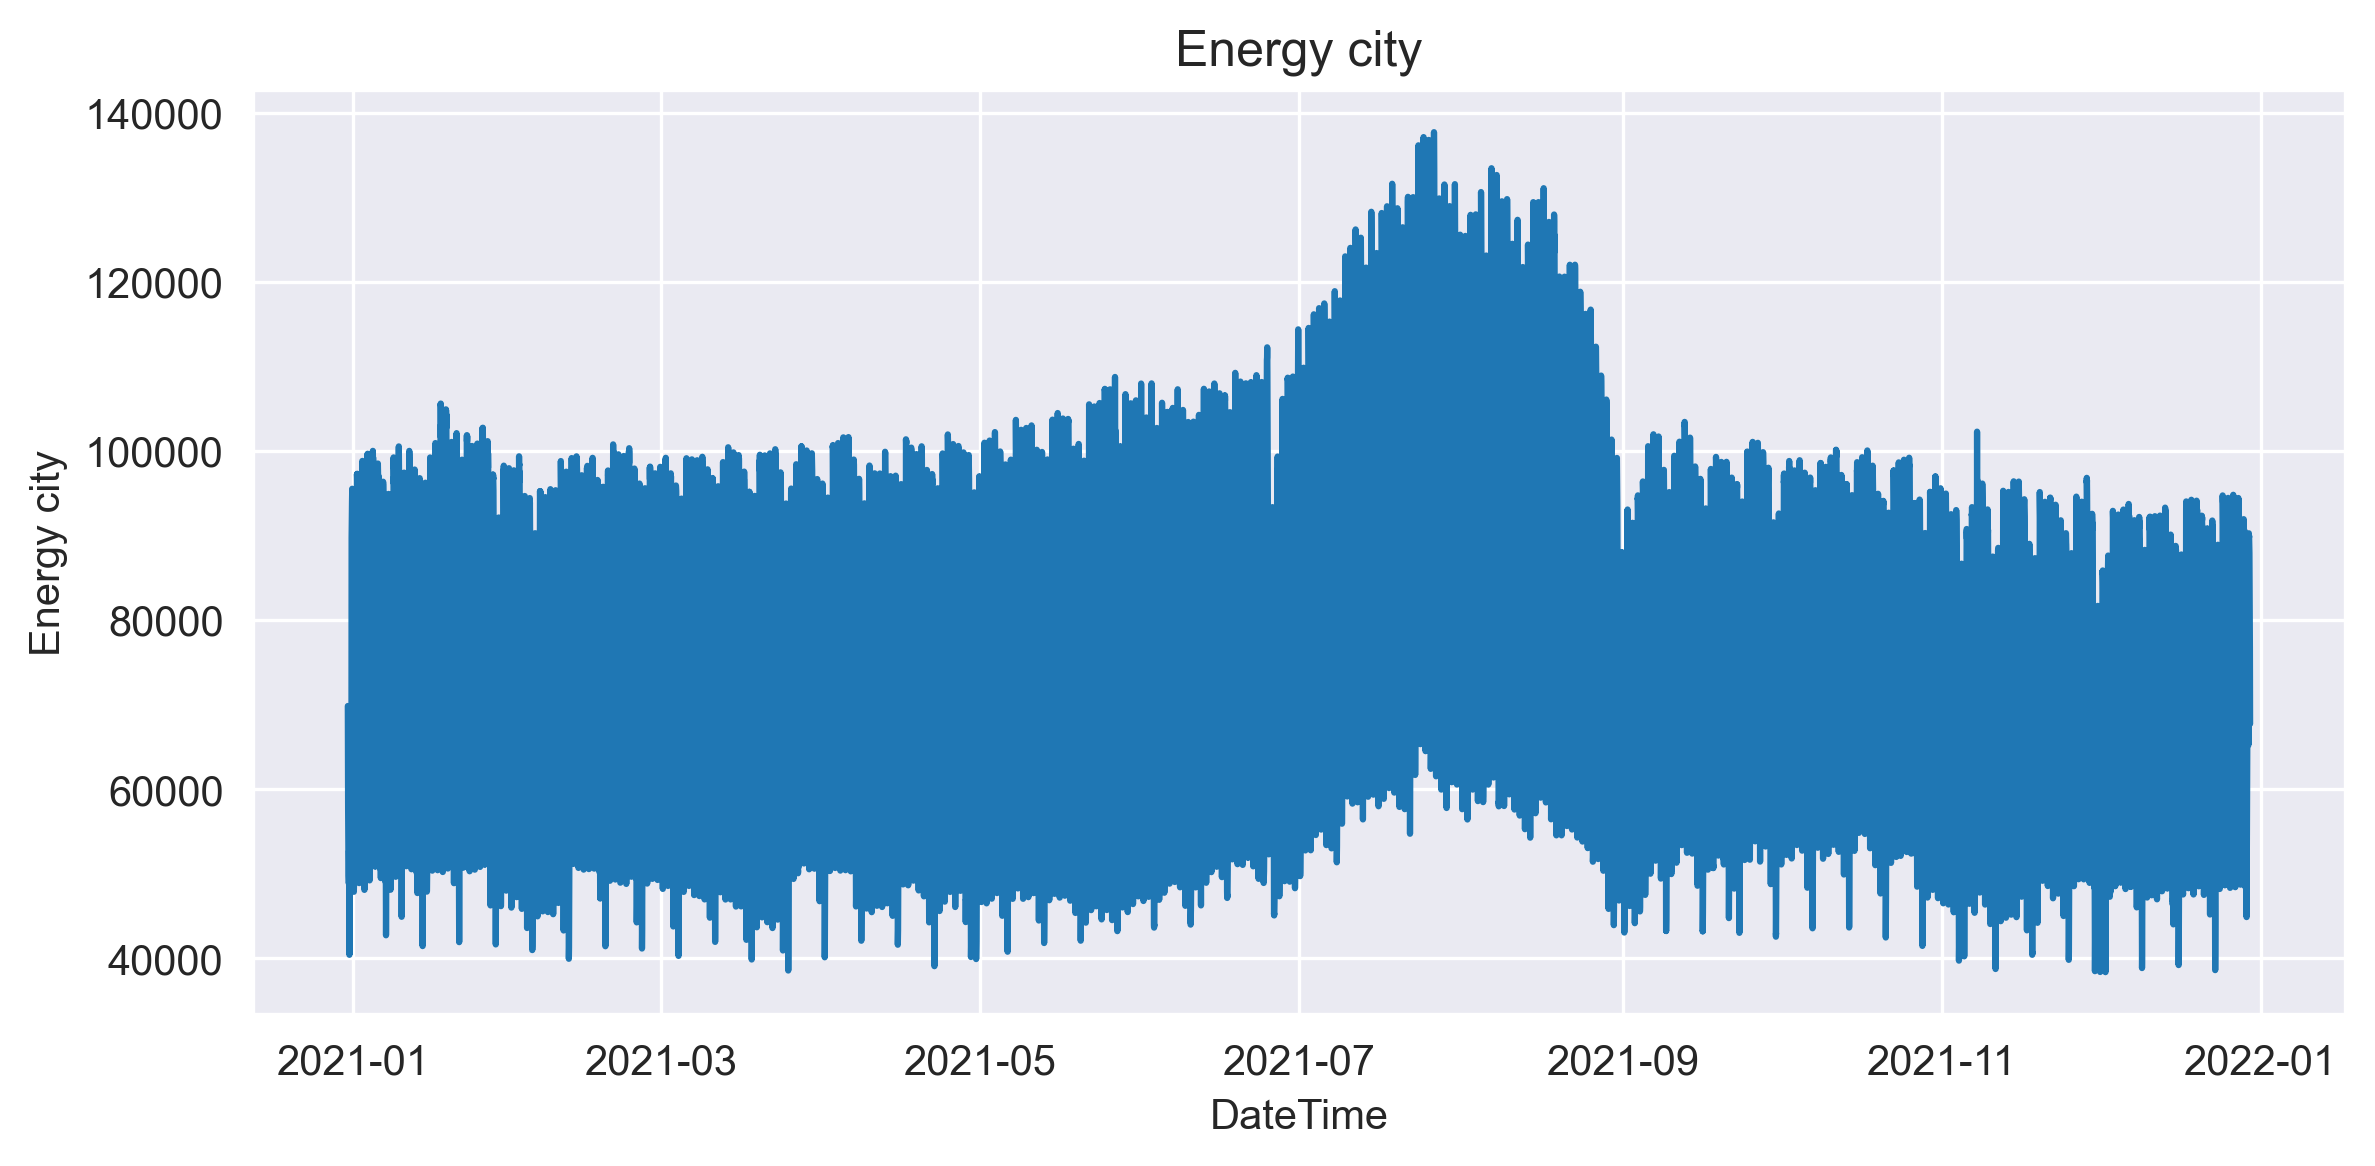

In [7]:
plt.figure(figsize=(9, 4), dpi=300)
sns.lineplot(data=train_data_preproc, x='DateTime', y='Energy city')
plt.title('Energy city')
plt.show()

In [8]:
X = train_data.iloc[:, :-1]
y = train_data['Energy city']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [9]:
datetime_preproc = DatetimeTransformer()
scaler = RobustScaler()
estimator_lgbm = LGBMRegressor(n_jobs=-1, n_estimators=1000, learning_rate=0.2)
estimator_pipeline = Pipeline([
    ('datetime', datetime_preproc),
    ('scaler', scaler),
    ('model', estimator_lgbm)
])

In [10]:
estimator_pipeline.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1377
[LightGBM] [Info] Number of data points in the train set: 28094, number of used features: 14
[LightGBM] [Info] Start training from score 73221.311588


Pipeline(steps=[('datetime', DatetimeTransformer()), ('scaler', RobustScaler()),
                ('model',
                 LGBMRegressor(learning_rate=0.2, n_estimators=1000,
                               n_jobs=-1))])

In [11]:
cv_score = cross_val_score(estimator_pipeline, X_train, y_train, scoring='r2', n_jobs=-1)
print(f'Mean CV: {cv_score.mean()}')

Mean CV: 0.9809569034624797


In [12]:
feature_importances = pd.DataFrame({'importance': estimator_lgbm.feature_importances_}, index=datetime_preproc.transform(X_train).columns)
feature_importances

,importance
Temperature,4889
Humidity,5147
Wind Speed,3480
general diffuse flows,3425
diffuse flows,3592
month,1180
weekday,1242
hour,1889
month_sin,547
month_cos,773


In [32]:
datetime_preproc = DatetimeTransformer()
scaler = RobustScaler()
estimator_lgbm = LGBMRegressor(n_jobs=-1)
estimator_pipeline = Pipeline([
    ('datetime', datetime_preproc),
    ('scaler', scaler),
    ('model', estimator_lgbm)
])

In [33]:
scoring = {
    'r2': 'r2',
    'mae': 'neg_mean_absolute_error'
}

def objective(params, pipeline, X, y):
    pipeline.set_params(**params),
    cv_scores = cross_validate(pipeline, X, y, scoring=scoring, n_jobs=-1)
    loss_r2 = -1 * cv_scores['test_r2'].mean()
    mean_mae= cv_scores['test_mae'].mean()
    return {'loss': loss_r2, 'mae': mean_mae, 'params': params, 'status': STATUS_OK}

optimize_fn = partial(objective, pipeline=estimator_pipeline, X=X_train, y=y_train)

In [34]:
space = {
    'model__n_estimators': scope.int(hp.quniform('n_estimators', 500, 1200, 50)),
    'model__max_depth': scope.int(hp.quniform('max_depth', 6, 16, 1)),
    'model__lerning_rate': hp.loguniform('learning_rate', np.log(0.1), np.log(0.7)),
    'model__reg_lambda': hp.uniform('reg_lambda', 0.1, 0.7),
    'model__num_leaves': scope.int(hp.uniform('num_leaves', 32, 256))
}

trials = Trials()
tune_lgbm = fmin(
    fn=optimize_fn,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(1),
    show_progressbar=True
)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

  1%|          | 1/100 [00:24<39:53, 24.18s/trial, best loss: -0.9807178052512414]


KeyboardInterrupt: 

In [ ]:
tune_lgbm

{'learning_rate': 0.34783086795487655,
 'max_depth': 11.0,
 'n_estimators': 1200.0,
 'reg_lambda': 0.10853337053422593}

In [ ]:
lgbm_model = LGBMRegressor(learning_rate=0.14783086795487655, max_depth=12, num_leaves=128, n_estimators=800, reg_lambda=0.10853337053422593)
datetime_preproc = DatetimeTransformer()
scaler = StandardScaler()
spline = SplineTransformer()
pipeline = Pipeline([
    ('datetime', datetime_preproc),
    ('scaler', scaler),
    ('spline', spline),
    ('model', lgbm_model)
])

In [ ]:
cv_score = cross_val_score(pipeline, X_train, y_train, cv=RepeatedKFold(n_splits=5, n_repeats=3, random_state=1), n_jobs=-1)

In [ ]:
cv_score.mean()

0.9804943478216169

In [ ]:
pipeline.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8007
[LightGBM] [Info] Number of data points in the train set: 28094, number of used features: 98
[LightGBM] [Info] Start training from score 73221.311588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

Pipeline(steps=[('datetime', DatetimeTransformer()),
                ('scaler', StandardScaler()), ('spline', SplineTransformer()),
                ('model',
                 LGBMRegressor(learning_rate=0.14783086795487654, max_depth=12,
                               n_estimators=800, num_leaves=128,
                               reg_lambda=0.10853337053422593))])

In [ ]:
r2_score(y_test, pipeline.predict(X_test))

0.9820146593684619

In [ ]:
preds = pipeline.predict(test_data.drop('Energy city', axis=1))
test_data['Energy city'] = preds

In [ ]:
test_data

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Energy city
0,12/31/2020/00:00,8.81577,73.80,0.08549,0.051,0.119,63684.812109
1,12/31/2020/00:10,8.66642,74.50,0.08549,0.070,0.085,67405.358407
4,12/31/2020/00:40,8.15863,75.70,0.08343,0.048,0.085,66383.149683
6,12/31/2020/01:00,7.87023,77.70,0.08240,0.048,0.096,58930.389471
7,12/31/2020/01:10,7.72088,78.20,0.08755,0.055,0.093,57400.754338
...,...,...,...,...,...,...,...
52398,12/29/2021/21:00,11.12400,65.49,0.08446,0.088,0.115,83597.428058
52402,12/29/2021/21:40,9.93950,71.10,0.08446,0.084,0.093,86324.650367
52404,12/29/2021/22:00,10.39270,68.49,0.08137,0.070,0.085,80810.648217
52405,12/29/2021/22:10,9.92920,70.10,0.08549,0.055,0.119,80724.244998


In [ ]:
test_data.to_csv('submit2.csv')

In [ ]:
space = {
    'model__n_estimators': scope.int(hp.quniform('n_estimators', 500, 1200, 50)),
    'model__max_depth': scope.int(hp.quniform('max_depth', 6, 16, 1)),
    'model__lerning_rate': hp.loguniform('learning_rate', np.log(0.1), np.log(0.7)),
    'model__reg_lambda': hp.uniform('reg_lambda', 0.1, 0.5),
    'model__num_leaves': scope.int(hp.quniform('num_leaves', 16, 128, 16))
}

trials = Trials()
tune_lgbm = fmin(
    fn=optimize_fn,
    space=space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials,
    rstate=np.random.default_rng(1),
    show_progressbar=True
)

100%|██████████| 20/20 [04:31<00:00, 13.55s/trial, best loss: -0.9820355618999953]


In [ ]:
tune_lgbm

{'learning_rate': 0.41546200468251515,
 'max_depth': 15.0,
 'n_estimators': 1100.0,
 'num_leaves': 112.0,
 'reg_lambda': 0.444279951233829}